### Part 1: Exploring and preparing the Data

In [1]:
# import relevant packages for data manipulation 
import pandas as pd
import numpy as np

# data package for visualization
import matplotlib.pyplot as plt

In [6]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()
bucket='sagemaker-busan'
data_key = 'train.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

In [7]:
df = pd.read_csv(data_location)

#### Initial exploration

In [8]:
# set viewing to avoid truncated columns
pd.set_option('display.max_columns', None)

# import data file
df = pd.read_csv("train.csv")

# look at the data
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [9]:
# Look at data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
id                        74111 non-null int64
log_price                 74111 non-null float64
property_type             74111 non-null object
room_type                 74111 non-null object
amenities                 74111 non-null object
accommodates              74111 non-null int64
bathrooms                 73911 non-null float64
bed_type                  74111 non-null object
cancellation_policy       74111 non-null object
cleaning_fee              74111 non-null bool
city                      74111 non-null object
description               74111 non-null object
first_review              58247 non-null object
host_has_profile_pic      73923 non-null object
host_identity_verified    73923 non-null object
host_response_rate        55812 non-null object
host_since                73923 non-null object
instant_bookable          74111 non-null object
last_review               582

#### Drop unnecessary features

- drop features that are irrelevant, unnecessary or out of project scope
- exclude variables that do not exist when initial listing price is determined i.e. variables that would create leakage
- looking at correlations between numeric variables, see a relationship between the number of bedrooms, beds, and how many people a listing accommodates. While this is not surprising, the correlations are sufficiently low (maximum = 0.81) that manual selection is not implemented here. Instead, algorithm-specific feature selection will be used down the line.

In [10]:
# drop features that are irrelevant, unnecessary or out of project scope
df1 = df.drop(['id', # remove id since it should not be in the feature set 
               'thumbnail_url', # remove image url
               'latitude', 'longitude', # remove highly-specific geo-encoding since 
               'neighbourhood', # large number of missing values, will be using zip code instead
                               #  Generally, location-based price adjustments should be captured with zip code and city
               'name', 'description'],  # remove text fields that are out of project scope, and likely add limited value
              axis=1)

# exclude variables that do not exist when initial listing price is determined i.e. variables that would create leakage
df1 = df1.drop(['first_review', 'last_review', 'number_of_reviews', 'review_scores_rating', 
              'host_response_rate', 'host_since'], axis=1)

In [11]:
# unsurprisingly, see some correlations between number of bedrooms, beds, and number of people accommodated.
# however, the coefficient values are sufficiently low (0.81) that we will rely on algorithmic feature selection instead 
df1.corr()

,log_price,accommodates,bathrooms,cleaning_fee,bedrooms,beds
log_price,1.000000,0.567574,0.355420,0.111191,0.473212,0.442153
accommodates,0.567574,1.000000,0.505632,0.182306,0.709258,0.810801
bathrooms,0.355420,0.505632,1.000000,0.053784,0.589935,0.525591
cleaning_fee,0.111191,0.182306,0.053784,1.000000,0.105454,0.131632
bedrooms,0.473212,0.709258,0.589935,0.105454,1.000000,0.709416
beds,0.442153,0.810801,0.525591,0.131632,0.709416,1.000000


#### Variable preparation: numeric variables

Explore numeric transformations for the data
- no negative or extreme values (that would warrant exclusion) observed
- the target variable, price, follows a normal distribution
- the remaining numeric X-features do not follow exact normal distributions, but did not benefit sufficiently from transformation to warrant changing. Square root, cube root, and log transforms (for variables that don't take zero-values) were attempted.

In [12]:
# look at summary statistics for numeric variables. 
# Some missing values for bedrooms, bath. No erroneous negative or extreme values observed.
df1.describe()

,log_price,accommodates,bathrooms,bedrooms,beds
count,74111.000000,74111.000000,73911.000000,74020.000000,73980.000000
mean,4.782069,3.155146,1.235263,1.265793,1.710868
std,0.717394,2.153589,0.582044,0.852143,1.254142
min,0.000000,1.000000,0.000000,0.000000,0.000000
25%,4.317488,2.000000,1.000000,1.000000,1.000000
50%,4.709530,2.000000,1.000000,1.000000,1.000000
75%,5.220356,4.000000,1.000000,1.000000,2.000000
max,7.600402,16.000000,8.000000,10.000000,18.000000


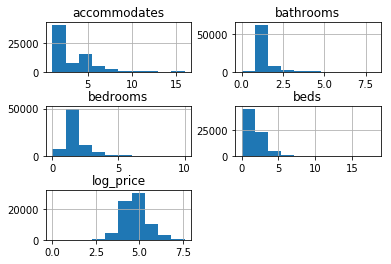

In [13]:
# look at numeric variable distributionss to see if transformation is needed.
num_vars = ['log_price', 'accommodates', 'bathrooms', 'bedrooms', 'beds'] # list of numeric columns
df1[num_vars].hist() # plot histogram for numeric variables
plt.subplots_adjust(hspace=0.7) # adjust spacing

# main variable of interest i.e. log_price looks to be normal

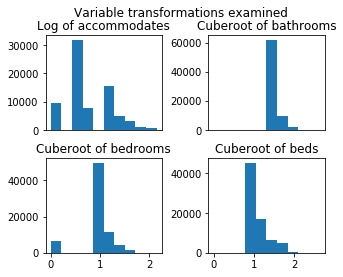

In [14]:
# check to see if transformations adds any value for remaining numeric variables
# visualization code adapted from https://matplotlib.org/gallery/subplots_axes_and_figures/subplots_demo.html

fig, axs = plt.subplots(2, 2, figsize=(5,4))
fig.suptitle('Variable transformations examined')
plt.subplots_adjust(wspace=0.4, hspace=0.3) # adjust spacing

# look at accommodates
# Tested sqrt, cbrt, and log. Log shown, none make variable noticeably normal. use raw.
axs[0,0].hist(np.log(df1.accommodates.dropna()))
axs[0,0].set_title('Log of accommodates')
axs[0,0].xaxis.set_visible(False)

# look at bathrooms. No benefit observed from cuberoot.
# Did not attempt log because takes on zero values.
axs[0,1].hist(np.cbrt(df1.bathrooms.dropna()))
axs[0,1].set_title('Cuberoot of bathrooms')
axs[0,1].xaxis.set_visible(False)

# look at bedrooms. No benefit observed from cuberoot.
# Did not attempt log because takes on zero values.
axs[1,0].hist(np.cbrt(df1.bedrooms.dropna()))
axs[1,0].set_title('Cuberoot of bedrooms')

# look at beds. No benefit observed from cuberoot.
# Did not attempt log because takes on zero values.
axs[1,1].hist(np.cbrt(df1.beds.dropna()))
axs[1,1].set_title('Cuberoot of beds');

#### Variable preparation: categorical variables

- Encode binary variables as categories
- Create n-1 dummy variables for multi-class categorical variables.
- Convert amenities into a series of dummy variables encoding each feature e.g. Wireless internet, air conditioning, etc.

In [15]:
# transform true/false features to binary
df1['host_has_profile_pic'] = df1['host_has_profile_pic'].map(lambda x: 0 if x == "f" else 1)
df1['host_identity_verified'] = df1['host_identity_verified'].map(lambda x: 0 if x == "f" else 1)
df1['instant_bookable'] = df1['instant_bookable'].map(lambda x: 0 if x == "f" else 1)
df1['cleaning_fee'] = df1['cleaning_fee'].map(lambda x: 0 if x == False else 1)

In [16]:
# clean zipcode prior to transformation to dummy variables
df1['zipcode'] = df1['zipcode'].astype(str)
df1['zipcode'] = df1['zipcode'].map(lambda x: x.strip('.0'))
df1['zipcode'] = df1['zipcode'].map(lambda x: x.strip('lm'))
df1['zipcode'] = df1['zipcode'].map(lambda x: x.strip('Near'))
df1['zipcode'] = df1['zipcode'].map(lambda x: x.replace("\n", ""))
df1['zipcode'] = df1['zipcode'].map(lambda x: x.replace("\r", ""))
df1['zipcode'] = df1['zipcode'].map(lambda x: x.replace("-", ""))
df1['zipcode'] = df1['zipcode'].map(lambda x: x.replace(" ", ""))
df1['zipcode'] = df1['zipcode'].map(lambda x: x[:5])
df1['zipcode'] = df1['zipcode'].map(lambda x: x.zfill(5))
df1['zipcode'] = df1['zipcode'].map(lambda x: x.replace("00nan", "NA"))

In [17]:
# transform categorical variables to dummies
df1['property_type'] = df1['property_type'].astype('category')
df1['room_type'] = df1['room_type'].astype('category')
df1['bed_type'] = df1['bed_type'].astype('category')

for i in ['cancellation_policy', 'property_type', 'room_type', 'bed_type', 'zipcode', 'city']:
    df1 = pd.concat([df1, pd.get_dummies(df1[i], drop_first=True)], axis=1)

In [18]:
# parse the amenities variable
df1['amenities'] = df1['amenities'].str.replace('{', '')
df1['amenities'] = df1['amenities'].str.replace('}', '')
df1['amenities'] = df1['amenities'].str.replace('"', '')

# make a tuple to store all the amenities
amenities_all = np.unique(np.concatenate(df1['amenities'].map(lambda x: x.split(","))))

# match each record's amenities
for amenity in amenities_all:
    df1[amenity] = df1['amenities'].map(lambda x: True if x.find(amenity) > 0 else False)

In [19]:
# drop variables that have been transformed into binary encoding
df1 = df1.drop(['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'zipcode', 'city', 'amenities'], axis=1)

In [20]:
# look at columns and updated data frame
df1.describe()

,log_price,accommodates,bathrooms,cleaning_fee,host_has_profile_pic,host_identity_verified,instant_bookable,bedrooms,beds,moderate,strict,super_strict_30,super_strict_60,Bed & Breakfast,Boat,Boutique hotel,Bungalow,Cabin,Camper/RV,Casa particular,Castle,Cave,Chalet,Condominium,Dorm,Earth House,Guest suite,Guesthouse,Hostel,House,Hut,In-law,Island,Lighthouse,Loft,Parking Space,Serviced apartment,Tent,Timeshare,Tipi,Townhouse,Train,Treehouse,Vacation home,Villa,Yurt,Private room,Shared room,Couch,Futon,Pull-out Sofa,Real Bed,00001,00021,00211,00212,00213,00221,01001,01003,01004,01027,01028,01031,01046,01047,01055,01121,01122,01123,01136,01137,01142,01158,02001,02002,02091,02108,02109,02111,02113,02114,02115,02116,02118,02119,02121,02122,02124,02125,02126,02127,02128,02129,02131,02132,02134,02135,02136,02138,02139,02143,02145,02152,02163,02186,02199,02215,02445,02446,02458,02467,02472,06061,06062,06063,06064,06066,07302,07306,09001,09002,09004,09021,09022,09023,09024,09025,09026,09028,09029,09063,09064,09065,09066,09067,09071,09081,09084,09101,09102,09103,09104,09121,09134,09135,09139,09174,09175,09177,09178,09179,09288,09355,09411,09413,10001,10002,10003,10004,10005,10006,10007,10009,10011,10012,10013,10014,10016,10017,10018,10019,10021,10022,10023,10024,10025,10026,10027,10028,10029,10031,10032,10033,10034,10035,10036,10037,10038,10039,10044,10048,10065,10069,10075,10106,10118,10119,10128,10129,10162,10279,10281,10282,10301,10302,10303,10304,10305,10306,10307,10308,10309,10312,10314,10451,10452,10453,10454,10455,10456,10457,10458,10459,10461,10462,10463,10464,10465,10466,10467,10468,10469,10471,10472,10473,10474,10475,10704,11001,11004,11101,11102,11103,11104,11105,11106,11109,11201,11203,11204,11205,11206,11207,11208,11209,11211,11212,11213,11214,11215,11216,11217,11218,11219,11221,11222,11223,11224,11225,11226,11228,11229,11231,11232,11233,11234,11235,11236,11237,11238,11239,11249,11354,11355,11356,11357,11358,11361,11362,11363,11364,11365,11366,11367,11368,11369,11372,11373,11374,11375,11377,11378,11379,11385,11411,11412,11413,11414,11415,11416,11417,11418,11419,11421,11422,11423,11426,11427,11428,11429,11432,11433,11434,11435,11436,11509,11691,11692,11693,11694,15074,20001,20002,20003,20004,20005,20006,20007,20008,20009,20011,20012,20015,20016,20017,20018,20019,20024,20032,20036,20037,20052,20064,20229,20268,20372,20712,20743,20748,20781,20782,20815,20816,20912,60302,60601,60602,60603,60605,60606,60607,60608,60609,60611,60612,60613,60614,60615,60616,60617,60618,60619,60621,60622,60623,60624,60625,60626,60628,60629,60631,60632,60633,60634,60636,60637,60638,60639,60641,60642,60643,60644,60645,60646,60647,60649,60651,60652,60653,60654,60656,60657,60659,60660,60661,60707,60805,90001,90002,90003,90004,90005,90006,90007,90008,90011,90012,90013,90014,90015,90016,90017,90018,90019,90021,90022,90023,90024,90025,90026,90027,90028,90029,90031,90032,90033,90034,90035,90036,90037,90038,90039,90041,90042,90043,90044,90045,90046,90047,90048,90049,90056,90057,90058,90059,90061,90062,90063,90064,90065,90066,90067,90068,90069,90071,90077,90094,90095,90201,90211,90212,90221,90222,90232,90241,90242,90245,90247,90248,90249,90254,90255,90262,90265,90266,90272,90274,90275,90277,90278,90291,90292,90293,90301,90302,90303,90304,90305,90401,90402,90403,90404,90405,90501,90502,90503,90504,90505,90601,90602,90603,90604,90605,90606,90631,90638,90701,90703,90704,90706,90712,90713,90715,90716,90717,90723,90731,90732,90744,90745,90746,90755,90802,90803,90804,90805,90806,90807,90808,90813,90814,90815,91001,91006,91007,91008,91011,91016,91024,91042,91101,91103,91104,91105,91106,91107,91108,91201,91202,91203,91204,91205,91206,91207,91208,91214,91301,91302,91303,91304,91306,91307,91308,91311,91316,91321,91324,91325,91326,91331,91335,91342,91343,91344,91345,91351,91352,91354,91355,91356,91361,91362,91364,91367,91377,91381,91384,91387,91401,91402,91403,91405,91406,91411,91423,91436,91501,91502,91504,91505,91506,91523,91601,91602,91604,91605,91606,91607,91702,917

A small number of missing values remain in the data set. Due to the complexity of imputing missing values for categorical variables and the larger number of observations in this data, all rows with missing values are removed.
The final data set has 73,766 observations acros 839 features.

In [21]:
# remove rows with missing values
df1 = df1.dropna()

In [22]:
# look at dimensions for final dataset
df1.shape

(73766, 839)

### Part 2: Model Building

In order to estimate the target variable of log_price, four different numeric prediction techniques are evaluated:

- regression tree
- knn regression
- lasso regression
- ridge regression

To build and evaluate these models, a combination of holdout and cross-validation is used.
- The dataset is first divied into training data (70% of observations) and test data (30% of observations).
- Cross-validation is used on the training data for each prediction technique to obtain optimal paramter values
- Models for each technique are then fitted on the training data using the best parameter inputs, and evaluated on the test data.

Given the large number of observations in the data, various versions of feature selection are relied on for each technique:

- regression tree: automatically performed using tree splitting criterion of mean squared error
- knn regression: tree-based feature selection used to create subset of features for knn regression
- lasso regression: contains automatic feature selection, supported by regularization parameter
- ridge regression: no direct feature exclusion, relies on regularization strength parameter for feature management

In [23]:
# Declare target attributes
X = df1.values[:, 1:] # X = all but first column
y = df1.values[:, 0] # y = first column i.e. log_price

In [24]:
# Split dataset for holdout testing

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=40) # 30% of data for test

#### Model 1: Regression tree

For the regression tree, the following parameter values are tested using GridSearch cross-validation on the training data:

- max_depth: [3, 4 , 5, 6...16]
- min_samples_leaf: [100, 500, 1000, 2000, 5000],
- max_leaf_nodes: [21, 23, 25, 27...61, None]

In [25]:
# setup grid search cross-validation

np.random.seed(55) # set default random seed generator for consistent results

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# specify gridsearch
tree = GridSearchCV(estimator=DecisionTreeRegressor(random_state=55), scoring='neg_mean_squared_error',
                  param_grid=[{'max_depth': list(range(3,17,1)), 
                              'min_samples_leaf':[100, 500, 1000, 2000, 5000],
                              'max_leaf_nodes':list(range(20,60,5))}],
                  cv=10,
                  n_jobs=10)

In [26]:
# implement gridsearch CV for regression tree on training data
# WARNING: takes long time to compute, avoid re-running
tree = tree.fit(X_train, y_train)

In [27]:
# view best score and parameters
print('Best tree MSE: %.4f'% (-tree.best_score_))
print('Best parameters:', tree.best_params_)

Best tree MSE: 0.2206
Best parameters: {'max_depth': 13, 'max_leaf_nodes': 55, 'min_samples_leaf': 100}


In [28]:
# fit final tree and get predictions
tree_final = tree.best_estimator_.fit(X_train,y_train)

# apply model to training and test data
y_pred_tree_train = tree_final.predict(X_train) # Apply model to train data
y_pred_tree_test = tree_final.predict(X_test)   # Apply model to test data

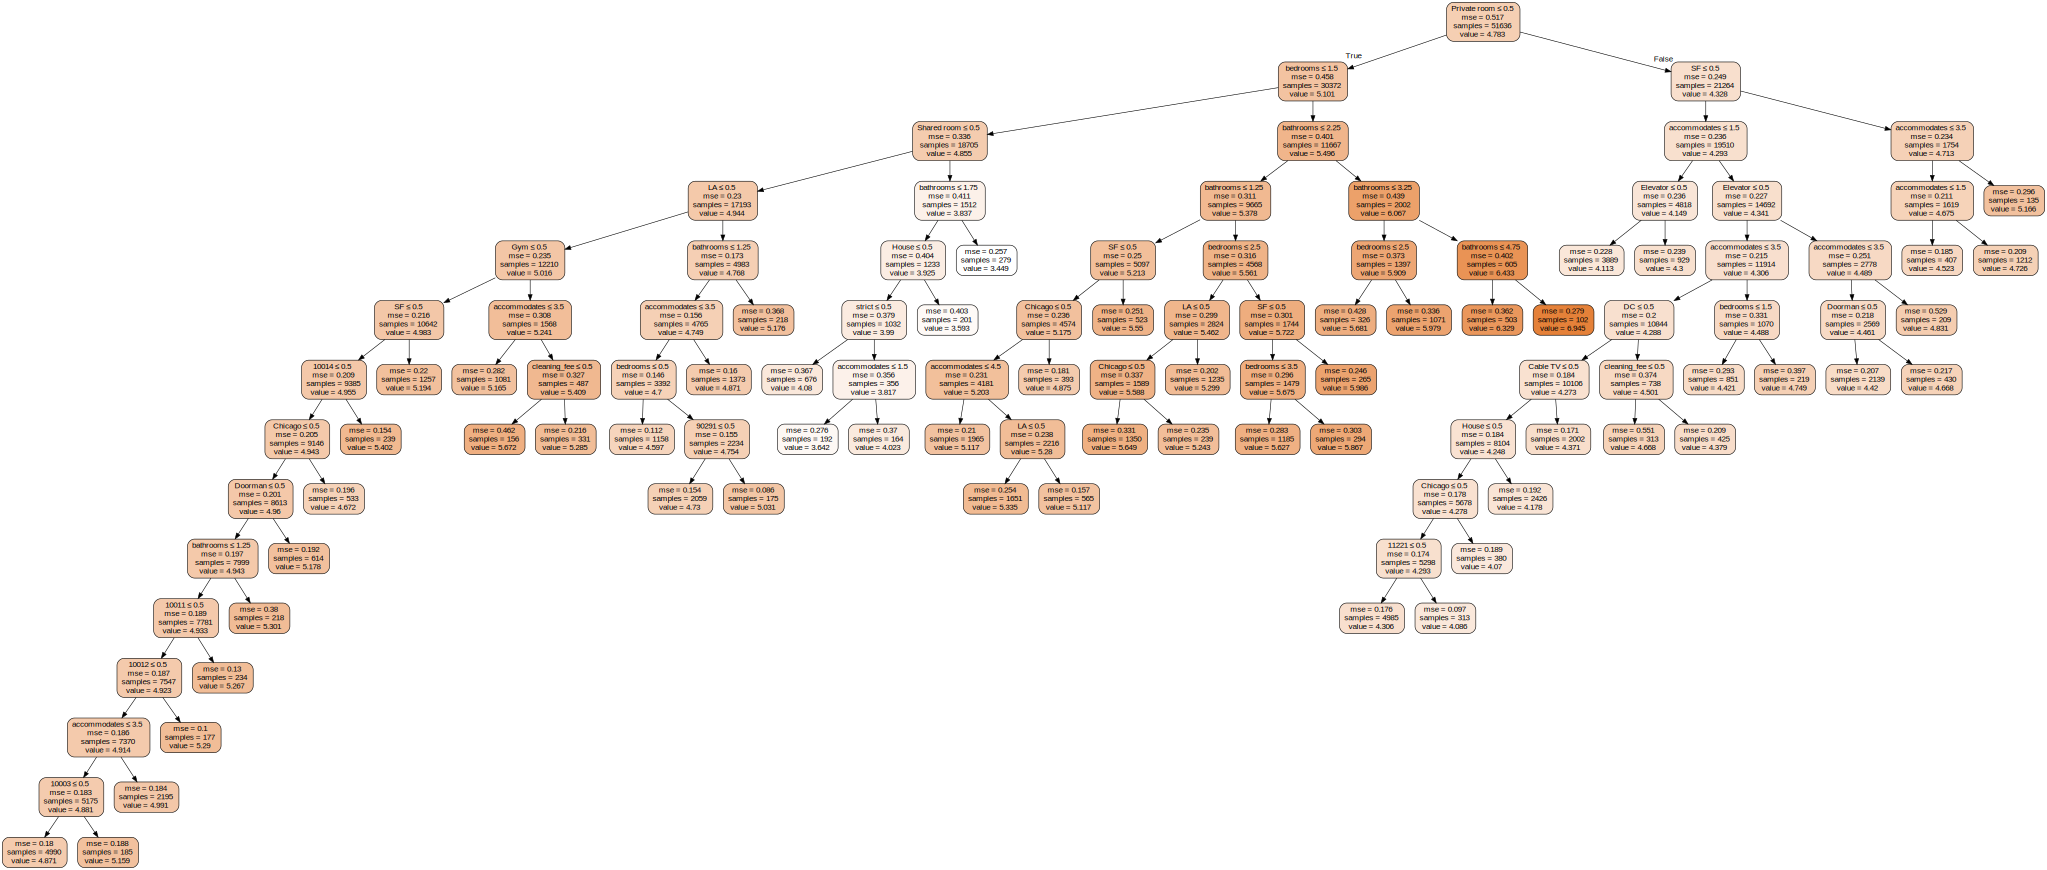

In [85]:
import graphviz 
from sklearn import tree

dot_data = tree.export_graphviz(tree_final, out_file=None,feature_names=df1.iloc[:, 1:].columns,
                         filled=True, rounded=True,  
                         special_characters=True)

graph = graphviz.Source(dot_data) 
graph

In [32]:
# evaluate model performance

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

# unlog training and prediction scores to get performance estimates in price units
y_pred_tree_train_unlog = np.exp(y_pred_tree_train)
y_pred_tree_test_unlog = np.exp(y_pred_tree_test)
y_train_unlog = np.exp((y_train).astype('float64'))
y_test_unlog = np.exp((y_test).astype('float64'))

# get root mean squared error
rmse_tree_train = np.sqrt(mean_squared_error(y_train_unlog, y_pred_tree_train_unlog))
rmse_tree_test = np.sqrt(mean_squared_error(y_test_unlog, y_pred_tree_test_unlog))

# get mean absolute error
mae_tree_train = mean_absolute_error(y_train_unlog, y_pred_tree_train_unlog)
mae_tree_test = mean_absolute_error(y_test_unlog, y_pred_tree_test_unlog)

# get explained variance score
evar_tree_train = explained_variance_score(y_train_unlog, y_pred_tree_train_unlog)
evar_tree_test = explained_variance_score(y_test_unlog, y_pred_tree_test_unlog)

In [33]:
# print performance results

print('Decision Tree Performance Results')
print('Root mean squared error (RMSE): train: %.3f, test: %.3f' % (rmse_tree_train, rmse_tree_test))
print('Mean absolute error (MAE): train: %.3f, test: %.3f' % (mae_tree_train, mae_tree_test))
print('Explained variance score: train: %.3f, test: %.3f' % (evar_tree_train, evar_tree_test))

Decision Tree Performance Results
Root mean squared error (RMSE): train: 130.256, test: 128.497
Mean absolute error (MAE): train: 60.269, test: 59.656
Explained variance score: train: 0.426, test: 0.416


#### Model 2: K-Nearest Neighbors Regression

Prior to building the k-nn model, feature selection is used to reduce the number of attributes included in model-building. Features are selected based on variance reduction, using multiple regression trees with mean squared error as splitting criterion, fit on the training data. Specficially, sklearn's extra trees regressor is used, a meta estimator that fits a number of randomized decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting (per description [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)).

The final features selected for model inclusion are then standardized.

Next, GridSearch cross-validation is used to find the best value of k-nn parameters on the training data. The values tested are shown below:
- k: [9, 11, 13, 15...31]
- weights: [uniform, distance]

In [34]:
# get rank of feature importances using extra trees regressor

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesRegressor(n_estimators=10)
clf = clf.fit(X_train, y_train)
clf.feature_importances_;

In [35]:
# create new subsets of feature training and test data based on top performing features
model = SelectFromModel(clf, prefit=True)
X_train_lim = model.transform(X_train) # feature subset for k-nn training
X_test_lim = model.transform(X_test) # feature subset for k-nn testing

# check how many features have been reduced
print('Training data shape before feature selection:', X_train.shape)
print('Training data shape after feature selection:', X_train_lim.shape)
print('Test data shape before feature selection:', X_test.shape)
print('Test data shape after feature selection:', X_test_lim.shape)

Training data shape before feature selection: (51636, 838)
Training data shape after feature selection: (51636, 89)
Test data shape before feature selection: (22130, 838)
Test data shape after feature selection: (22130, 89)


In [36]:
# standardize the features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train_lim)
X_train_std = sc.transform(X_train_lim)
X_test_std = sc.transform(X_test_lim)

# look at mean and std of standardized data
print('mean: ', np.round(np.mean(X_train_std),4))
print('std: ', np.round(np.std(X_train_std),4))

mean:  0.0
std:  1.0


In [39]:
# setup grid search cross-validation for knn
from sklearn.neighbors import KNeighborsRegressor

knn = GridSearchCV(estimator=KNeighborsRegressor(p=2, metric='minkowski'),
                   param_grid=[{'n_neighbors': list(range(9,21,2)),
                   'weights':['uniform','distance']}],
                   scoring='neg_mean_squared_error',
                   cv=10,
                   n_jobs=-1)

In [88]:
# setup grid search cross-validation for knn
from sklearn.neighbors import KNeighborsRegressor

knn = GridSearchCV(estimator=KNeighborsRegressor(p=2, metric='minkowski', weights='distance'),
                   param_grid=[{'n_neighbors': list(range(11,21,2))}],
                                scoring='neg_mean_squared_error',
                   cv=10,
                   n_jobs=-1)

In [89]:
# implement gridsearch CV for k-NN regression on training data
# WARNING: takes long time to compute, avoid re-running

knn = knn.fit(X_train_std, y_train)

In [90]:
# view best score and parameters
print('Best knn MSE: %.4f'% (-knn.best_score_))
print('Best parameters:', knn.best_params_)

Best knn MSE: 0.2280
Best parameters: {'n_neighbors': 17}


In [91]:
# fit final model and get predictions
knn_final = knn.best_estimator_.fit(X_train_std,y_train)

# apply model to training and test data
y_pred_knn_train = knn_final.predict(X_train_std) # Apply model to train data
y_pred_knn_test = knn_final.predict(X_test_std)   # Apply model to test data

In [97]:
# evaluate model performance

# unlog prediction scores to get performance estimates in price units
y_pred_knn_train_unlog = np.exp(y_pred_knn_train)
y_pred_knn_test_unlog = np.exp(y_pred_knn_test)

# get root mean squared error
rmse_knn_train = np.sqrt(mean_squared_error(y_train_unlog, y_pred_knn_train_unlog))
rmse_knn_test = np.sqrt(mean_squared_error(y_test_unlog, y_pred_knn_test_unlog))

# get mean absolute error
mae_knn_train = mean_absolute_error(y_train_unlog, y_pred_knn_train_unlog)
mae_knn_test = mean_absolute_error(y_test_unlog, y_pred_knn_test_unlog)

# get explained variance score
evar_knn_train = explained_variance_score(y_train_unlog, y_pred_knn_train_unlog)
evar_knn_test = explained_variance_score(y_test_unlog, y_pred_knn_test_unlog)

In [98]:
# print performance results

print('k-NN regression Performance Results')
print('Root mean squared error (RMSE): train: %.3f, test: %.3f' % (rmse_knn_train, rmse_knn_test))
print('Mean absolute error (MAE): train: %.3f, test: %.3f' % (mae_knn_train, mae_knn_test))
print('Explained variance score: train: %.3f, test: %.3f' % (evar_knn_train, evar_knn_test))

k-NN regression Performance Results
Root mean squared error (RMSE): train: 7.822, test: 130.432
Mean absolute error (MAE): train: 0.298, test: 60.070
Explained variance score: train: 0.998, test: 0.406


#### Model 3: Lasso regression

GridSearch cross-validation is used to find the best value of alpha (regularization strength) on the training data. 
The values tested are shown below:
- alpha: [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 500]

In [44]:
# setup grid search cross-validation for lasso regression

from sklearn.linear_model import Lasso

lasso = GridSearchCV(estimator=Lasso(random_state=75),
                     param_grid= [{'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 500]}],
                     scoring='neg_mean_squared_error',
                     cv=10, iid=False,
                     n_jobs=-1)

In [45]:
# implement gridsearch CV for lasso regression on training data
# WARNING: takes long time to compute, avoid re-running

lasso = lasso.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [46]:
# view best score and parameters
print('Best lasso MSE: %.4f'% (-lasso.best_score_))
print('Best parameters:', lasso.best_params_)

Best lasso MSE: 0.1716
Best parameters: {'alpha': 1e-05}


In [47]:
# fit final model and get predictions
lasso_final = lasso.best_estimator_.fit(X_train,y_train)

# apply model to training and test data
y_pred_lasso_train = lasso_final.predict(X_train) # Apply model to train data
y_pred_lasso_test = lasso_final.predict(X_test)   # Apply model to test data

In [48]:
# evaluate model performance

# unlog prediction scores to get performance estimates in price units
y_pred_lasso_train_unlog = np.exp(y_pred_lasso_train)
y_pred_lasso_test_unlog = np.exp(y_pred_lasso_test)

# get root mean squared error
rmse_lasso_train = np.sqrt(mean_squared_error(y_train_unlog, y_pred_lasso_train_unlog))
rmse_lasso_test = np.sqrt(mean_squared_error(y_test_unlog, y_pred_lasso_test_unlog))

# get mean absolute error
mae_lasso_train = mean_absolute_error(y_train_unlog, y_pred_lasso_train_unlog)
mae_lasso_test = mean_absolute_error(y_test_unlog, y_pred_lasso_test_unlog)

# get explained variance score
evar_lasso_train = explained_variance_score(y_train_unlog, y_pred_lasso_train_unlog)
evar_lasso_test = explained_variance_score(y_test_unlog, y_pred_lasso_test_unlog)

In [49]:
# print performance results

print('Lasso regression Performance Results')
print('Root mean squared error (RMSE): train: %.3f, test: %.3f' % (rmse_lasso_train, rmse_lasso_test))
print('Mean absolute error (MAE): train: %.3f, test: %.3f' % (mae_lasso_train, mae_lasso_test))
print('Explained variance score: train: %.3f, test: %.3f' % (evar_lasso_train, evar_lasso_test))

Lasso regression Performance Results
Root mean squared error (RMSE): train: 121.020, test: 119.827
Mean absolute error (MAE): train: 52.481, test: 52.534
Explained variance score: train: 0.502, test: 0.489


#### Model 4: Ridge regression

GridSearch cross-validation is used to find the best value of alpha (regularization strength) on the training data. 
The values tested are shown below:
- alpha: [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 500]

In [51]:
# setup grid search cross-validation for ridge regression

from sklearn.linear_model import Ridge

ridge = GridSearchCV(estimator=Ridge(random_state=75),
                     param_grid= [{'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 500]}],
                     scoring='neg_mean_squared_error',
                     cv=10, iid=False,
                     n_jobs=-1)

In [52]:
# implement gridsearch CV for Ridge regression on training data
# WARNING: takes long time to compute, avoid re-running

ridge = ridge.fit(X_train, y_train)

In [53]:
# view best score and parameters
print('Best ridge MSE: %.4f'% (-ridge.best_score_))
print('Best parameters:', ridge.best_params_)

Best ridge MSE: 0.1716
Best parameters: {'alpha': 1}


In [54]:
# fit final model and get predictions
ridge_final = ridge.best_estimator_.fit(X_train,y_train)

# apply model to training and test data
y_pred_ridge_train = ridge_final.predict(X_train) # Apply model to train data
y_pred_ridge_test = ridge_final.predict(X_test)   # Apply model to test data

In [55]:
# evaluate model performance

# unlog prediction scores to get performance estimates in price units
y_pred_ridge_train_unlog = np.exp(y_pred_ridge_train)
y_pred_ridge_test_unlog = np.exp(y_pred_ridge_test)

# get root mean squared error
rmse_ridge_train = np.sqrt(mean_squared_error(y_train_unlog, y_pred_ridge_train_unlog))
rmse_ridge_test = np.sqrt(mean_squared_error(y_test_unlog, y_pred_ridge_test_unlog))

# get mean absolute error
mae_ridge_train = mean_absolute_error(y_train_unlog, y_pred_ridge_train_unlog)
mae_ridge_test = mean_absolute_error(y_test_unlog, y_pred_ridge_test_unlog)

# get explained variance score
evar_ridge_train = explained_variance_score(y_train_unlog, y_pred_ridge_train_unlog)
evar_ridge_test = explained_variance_score(y_test_unlog, y_pred_ridge_test_unlog)

In [57]:
# print performance results

print('Ridge regression Performance Results')
print('Root mean squared error (RMSE): train: %.3f, test: %.3f' % (rmse_ridge_train, rmse_ridge_test))
print('Mean absolute error (MAE): train: %.3f, test: %.3f' % (mae_ridge_train, mae_ridge_test))
print('Explained variance score: train: %.3f, test: %.3f' % (evar_ridge_train, evar_ridge_test))

Ridge regression Performance Results
Root mean squared error (RMSE): train: 121.002, test: 119.730
Mean absolute error (MAE): train: 52.441, test: 52.530
Explained variance score: train: 0.502, test: 0.490


In [70]:
# average data
print("Average price of training: ", np.round(np.mean(y_train_unlog),2))
print("Average price of test: ", np.round(np.mean(y_test_unlog), 2))

Average price of training:  160.73
Average price of test:  160.04


### Fitting curves

In [ ]:
# WARNING: Cell takes time to compute
# Get data points for fitting curve via cross validation on training data

# Fitting curve (aka validation curve)

# Determine training and test scores for varying parameter values.
from sklearn.model_selection import validation_curve

# Specify possible parameter values for alpha, the regularization strength.
param_range = [0.00001, 0.0001, 0.001, 0.01, 0.1 ,1 ,10 ,100, 1000, 10000, 100000, 1000000, 10000000]

# Compute scores for an estimator with different values of a specified parameter. 
# This is similar to grid search with one parameter. 
# However, this will also compute training scores and is merely a utility for plotting the results.

# Determine training and test scores for varying parameter values.
train_scores, test_scores = validation_curve( 
                estimator=Lasso(random_state=55), #Build regression model
                X=X_train, 
                y=y_train, 
                param_name="alpha", # parameter alpha: regularization strength;
                param_range=param_range,
                cv=10,     #10-fold cross-validation
                scoring="neg_mean_squared_error", 
                n_jobs=-1) # Number of CPU cores used when parallelizing over classes if multi_class=’ovr’”. 


# Cross validation statistics for training and testing data (mean and standard deviation)
train_mean = -np.mean(train_scores, axis=1) # Compute the arithmetic mean along the specified axis.
train_std = np.std(train_scores, axis=1)   # Compute the standard deviation along the specified axis.
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


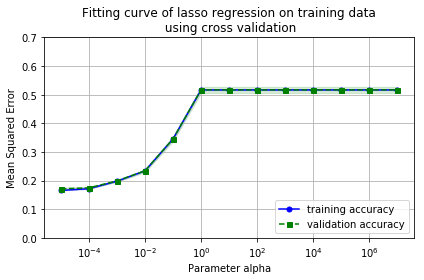

In [65]:
# make plot

# Plot train accuracy means of cross-validation for all the parameters in param_range
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the training data
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

# Plot test accuracy means of cross-validation for all the parameters in param_range
plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

# Fill the area around the line to indicate the size of standard deviations of performance for the test data
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

# Grid and Axes Titles
plt.grid()
plt.title('Fitting curve of lasso regression on training data\n using cross validation')
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter alpha')
plt.ylabel('Mean Squared Error')
plt.ylim([0.0, 0.7]) # y limits in the plot
plt.tight_layout()
# plt.savefig('Fitting_graph_LR.png', dpi=300)
plt.show()           #display the figure